In [63]:
import biobss
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
data, info = biobss.utils.load_sample_data(data_type='PPG_LONG')
sig = np.asarray(data['PPG'])
fs = info['sampling_rate']
L = info['signal_length']

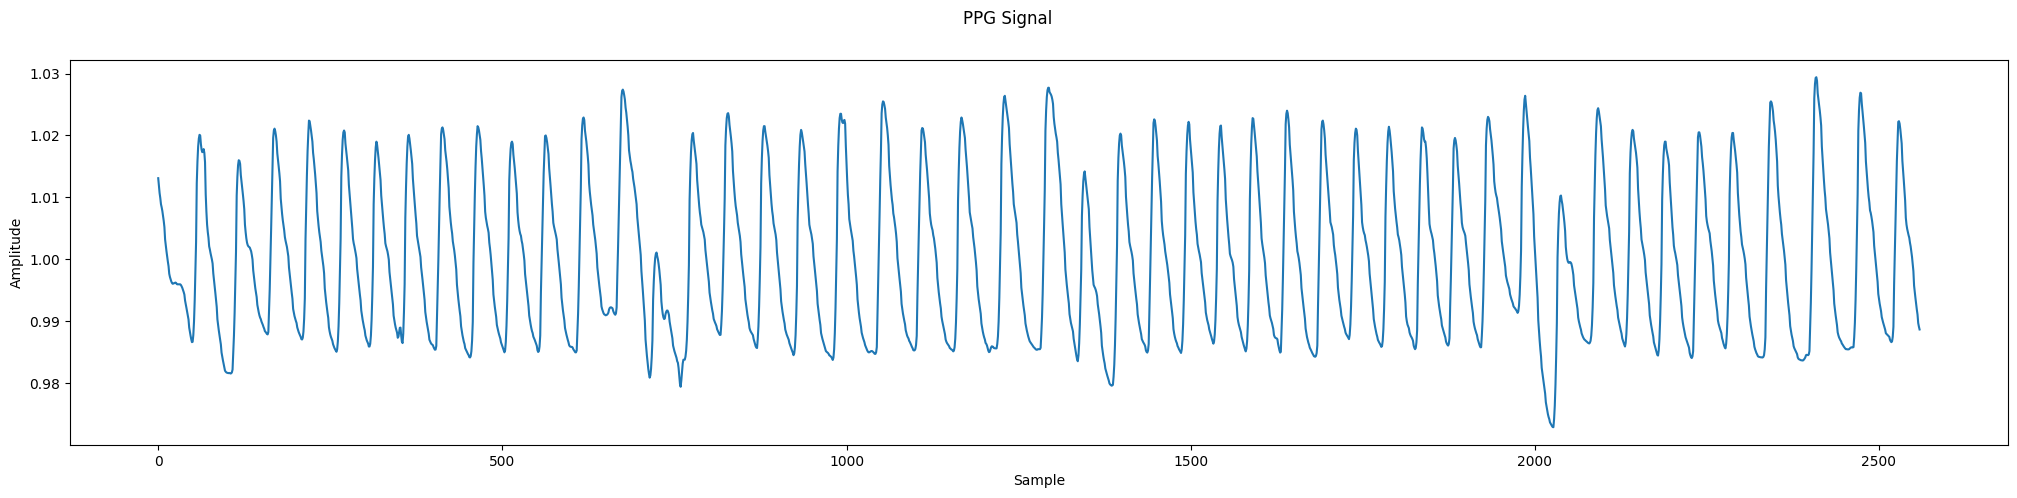

In [65]:
plt.figure(figsize=(25, 5))
plt.suptitle('PPG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.plot(sig);

### Creating Pipeline
Create pipeline object.


In [66]:
pipeline = biobss.pipeline.Bio_Pipeline()   # Create a pipeline object
pipeline.set_input(data = sig, sampling_rate = fs , name= 'PPG') # Set the input signal and sampling rate

### Processing Steps
 1. Filtering signals
    * Signal can be filtered with defining filters
      * <code> biobss.preprocess.filter_signal(sig,sampling_rate=fs,filter_type='bandpass',N=2,f_lower=0.5,f_upper=5) </code>
    * Siganls can be filtered with predefined filters
      * <code> biobss.preprocess.filter_signal(sig, sampling_rate=fs, signal_type='PPG', method='bandpass') </code>
 2. Peak Detection

In [67]:
# First we can define the processes as a Bio_Process object
filter_ppg = biobss.pipeline.Bio_Process(biobss.preprocess.filter_signal,process_name='Filter PPG',
                                         filter_type='bandpass',N=2,f_lower=0.5,f_upper=5)

# Note that we did not add the process to the pipeline yet, some arguments can be added
# while adding the process to the pipeline

find_peaks = biobss.pipeline.Bio_Process(biobss.ppgtools.ppg_detectpeaks,process_name='Find Peaks',
                                         method='peakdet', delta=0.01, correct_peaks=True)

In [68]:
pipeline.process_queue.add_process(filter_ppg , input_signals=['PPG'], output_signals=['PPG_Filtered'], sampling_rate = fs)
pipeline.process_queue.add_process(find_peaks , input_signals=['PPG_Filtered'], output_signals=['PPG_Peaks'], sampling_rate = fs,is_event=True)

In [69]:
pipeline.run_pipeline()

In [70]:
pipeline.data

Signal object with 4 channel(s)
PPG (64Hz) (1 windows) ((2560,))
PPG_Filtered (64Hz) (1 windows) ((2560,))
PPG_Peaks_Peak_locs (64Hz) (1 windows)
PPG_Peaks_Trough_locs (64Hz) (1 windows)

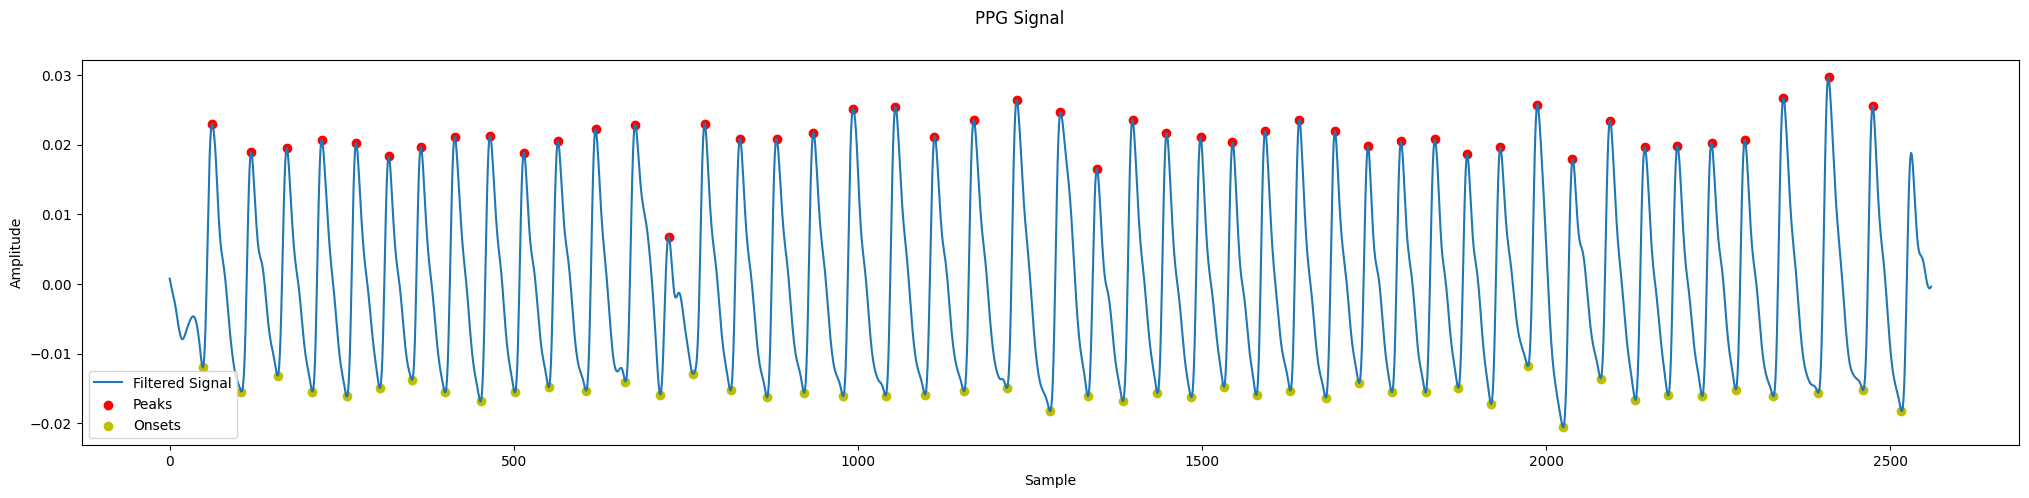

In [71]:
plt.figure(figsize=(25, 5))
plt.suptitle('PPG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.plot(pipeline.data ['PPG_Filtered'].channel)
plt.scatter(pipeline.data ['PPG_Peaks_Peak_locs'].channel,
            pipeline.data ['PPG_Filtered'].channel[pipeline.data ['PPG_Peaks_Peak_locs'].channel],c='r');
plt.scatter(pipeline.data ['PPG_Peaks_Trough_locs'].channel,
            pipeline.data ['PPG_Filtered'].channel[pipeline.data ['PPG_Peaks_Trough_locs'].channel],c='y');

plt.legend(['Filtered Signal','Peaks','Onsets']);

### Define the features

In [72]:
ppg_freq = biobss.pipeline.feature_extraction.Feature(function = biobss.ppgtools.ppg_features.ppg_freq_features,name='PPG_Frequency', input_types=['segment'])
ppg_stat = biobss.pipeline.feature_extraction.Feature(function = biobss.ppgtools.ppg_features.ppg_stat_features,name='PPG_Statistics', input_types=['segment'])

### Add the features to the pipeline

In [51]:
pipeline.add_feature_step(ppg_freq, input_signals=['PPG_Filtered'], sampling_rate = fs)
pipeline.add_feature_step(ppg_stat, input_signals=['PPG_Filtered'], sampling_rate = fs)

### Extract the features

In [52]:
pipeline.extract_features()
pipeline.features

,ppg_p_1,ppg_f_1,ppg_p_2,ppg_f_2,ppg_p_3,ppg_f_3,ppg_pow,ppg_rpow,ppg_mean,ppg_median,ppg_std,ppg_pct_25,ppg_pct_75,ppg_mad,ppg_skewness,ppg_kurtosis,ppg_entropy
None,0.007533,1.3,0.004901,1.25,0.00441,1.175,0.000129,0.876702,-0.00005,-0.00172,0.01218,-0.011324,0.009579,1.517883e-19,0.405716,-1.056342,11.321928


### Define and Run Pipeline as a windowed process

In [53]:
pipeline_windowed = biobss.pipeline.Bio_Pipeline(windowed_process=True,window_size=20,step_size=5)  # Create a pipeline object
pipeline_windowed.set_input(data = sig, sampling_rate = fs , name= 'PPG') # Set the input signal and sampling rate

In [54]:
# First we can define the processes as a Bio_Process object
filter_ppg = biobss.pipeline.Bio_Process(biobss.preprocess.filter_signal,process_name='Filter PPG',
                                         filter_type='bandpass',N=2,f_lower=0.5,f_upper=5)

# Note that we did not add the process to the pipeline yet, some arguments can be added
# while adding the process to the pipeline

find_peaks = biobss.pipeline.Bio_Process(biobss.ppgtools.ppg_detectpeaks,process_name='Find Peaks',
                                         method='peakdet', delta=0.01, correct_peaks=True)

pipeline_windowed.process_queue.add_process(filter_ppg , input_signals=['PPG'], output_signals=['PPG_Filtered'], sampling_rate = fs)
pipeline_windowed.process_queue.add_process(find_peaks , input_signals=['PPG_Filtered'], output_signals=['PPG_Peaks'], sampling_rate = fs,is_event=True)

In [55]:
pipeline_windowed.run_pipeline()
pipeline_windowed.data

Signal object with 4 channel(s)
PPG (64Hz) (5 windows) ((5, 1280))
PPG_Filtered (64Hz) (5 windows) ((5, 1280))
PPG_Peaks_Peak_locs (64Hz) (5 windows)
PPG_Peaks_Trough_locs (64Hz) (5 windows)

In [56]:
ppg_freq = biobss.pipeline.feature_extraction.Feature(function = biobss.ppgtools.ppg_features.ppg_freq_features,name='PPG_Frequency', input_types=['segment'])
ppg_stat = biobss.pipeline.feature_extraction.Feature(function = biobss.ppgtools.ppg_features.ppg_stat_features,name='PPG_Statistics', input_types=['segment'])
pipeline_windowed.add_feature_step(ppg_freq, input_signals=['PPG_Filtered'], sampling_rate = fs)
pipeline_windowed.add_feature_step(ppg_stat, input_signals=['PPG_Filtered'], sampling_rate = fs)


In [57]:
pipeline_windowed.extract_features()
pipeline_windowed.features

,ppg_p_1,ppg_f_1,ppg_p_2,ppg_f_2,ppg_p_3,ppg_f_3,ppg_pow,ppg_rpow,ppg_mean,ppg_median,ppg_std,ppg_pct_25,ppg_pct_75,ppg_mad,ppg_skewness,ppg_kurtosis,ppg_entropy
0,0.007803,1.25,0.007307,1.15,0.002233,2.20,0.000123,0.875415,-0.000088,-0.002076,0.011827,-0.011022,0.008942,4.228388e-19,0.434868,-1.038770,10.321928
1,0.008605,1.25,0.006156,1.15,0.002223,0.85,0.000131,0.879826,-0.000101,-0.001877,0.012341,-0.011780,0.009843,5.204170e-19,0.406350,-1.118059,10.321928
2,0.006768,1.15,0.006592,1.25,0.006158,1.35,0.000132,0.875440,-0.000035,-0.001767,0.012243,-0.011344,0.009641,2.602085e-19,0.413128,-1.076646,10.321928
3,0.010495,1.30,0.006403,1.10,0.002744,2.60,0.000132,0.870956,-0.000034,-0.001912,0.012595,-0.011346,0.010150,-3.469447e-19,0.395298,-1.073960,10.321928
4,0.011446,1.30,0.005609,1.20,0.003222,2.60,0.000130,0.864068,0.000297,-0.000904,0.012623,-0.011324,0.010401,-1.951564e-19,0.412557,-0.941865,10.321928
